## License Information
---

This file is distributed as part of `swprepost`, a Python package for surface wave inversion pre- and post-processing.

    Copyright (C) 2019-2020 Joseph P. Vantassel (jvantassel@utexas.edu)

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https: //www.gnu.org/licenses/>.
    
## About SWinvert, `swprepost`, and this notebook
---

SWinvert is an open-source workflow for performing rigorous surface wave inversion. `swprepost` is a Python package for performing surface wave inversion pre- and post-processing. This notebook is __an__ example of a workflow that can be built using the concepts from SWinvert and the tools available from `swprepost`. The SWinvert workflow, `swprepost`, and this notebook were developed by Joseph P. Vantassel, under the supervision of Brady R. Cox at the University of Texas at Austin. If you use this notebook and/or `swprepost` in your research we ask that you please cite the following:

>Citation Forthcoming


## Using this notebook

This notebook has four main parts:

1. [Defining the inversion target](#Defining-the-Inversion-Target)
2. [Selecting the inversion parameterizations](#Selecting-the-Inversion-Parameterizations)
3. [Running the inversion](#Running-the-Inversion)
4. [Post-processing the inversion results](#Post-processing-the-Inversion-Results)


### An important note

__This notebook is intended as a tool to expedite surface wave inversion, however it is of paramount importance that the user have some working knowledge of surface wave inversion to understand what they are doing. We strongly recommend that this notebook not be used as "black-box" software. At a minimum we recommend the user to read Vantassel and Cox (2020), citation above, to familiarize themselves with the basics of surface wave inversion and the specific recommendations presented therein__.

All the best 

\- Joe

## Imports and Function Definitions

In [1]:
import glob, re, os

import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

import swprepost

def plotter(tar):
    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(6,3), dpi=150)
    tar.plot(x="frequency", y="velocity", ax=axs[0])
    tar.plot(x="wavelength", y="velocity", ax=axs[1])
    axs[1].set_ylabel("")
    axs[1].legend()
    
def on_button_click(*args, **kwargs):
    global tar
    click.clear_output()
    button.description = 'Plotting'
    with click:
        if tar.is_no_velstd:
            tar.setcov(ecov.value)
        else:
            tar.setmincov(ecov.value)
        plotter(tar)
        button.description = 'Done'

def change_options(*args):
    global tar
    tar=swprepost.Target.from_csv(fname.value)
    if tar.is_no_velstd: 
        ecov.description = 'COV:'
        ecov.options = {'COV=0.05':0.05,'COV=0.075':0.075,'COV=0.1':0.1}
    else: 
        ecov.description = 'Min COV:'
        ecov.options = {'Provided':0, 'COV=0.05':0.05,'COV=0.075':0.075,'COV=0.1':0.1}
print("Imports completed, please continue.")

Imports completed, please continue.


## Defining the Inversion Target

### Importing the Experimental Dispersion Data

1. Run the cell.
2. Use the left dropdown menu to select the file containing your experimental disperison data.
3. If no uncertainty is provided use the right dropdown menu to select an appropriate coefficient of variation (COV).
4. Press `Load` when ready.
5. Review the figure to ensure your data has loaded correctly, then proceed to the next cell.

[Back to top](#License-Information)

Output()

Output()

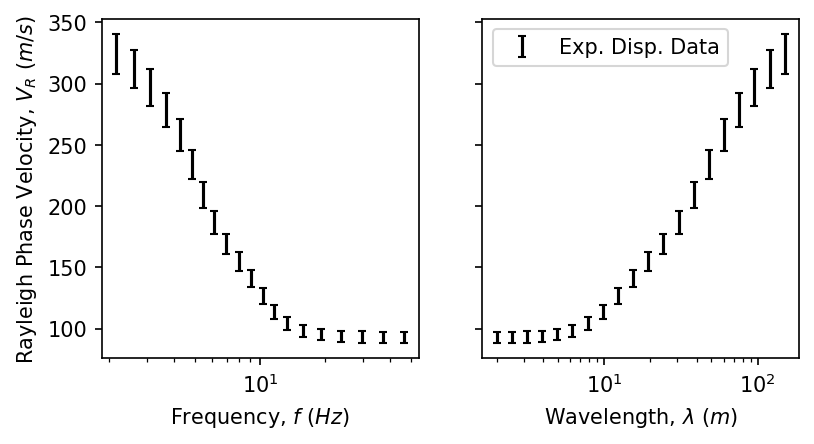

In [2]:
csvs = glob.glob('*.csv')
init = widgets.Output()
fname = widgets.Dropdown(options=['Select Experimental Dispersion Data File'] + csvs,
                        description='File Name:')
ecov=widgets.Dropdown(options={' ':None}, description='COV')
button=widgets.Button(description='Load')
fname.observe(change_options,names='value'); display(init)
ui=widgets.HBox(children=[fname, ecov, button])
click = widgets.Output(); button.on_click(on_button_click); display(ui,click)

### Resampling the Experimental Disperison

1. Select the `domain` in which you wish to resample. _wavelength is recommended._
2. Select the `resample_type` either log or linear. _log is recommended._
3. Select the minimum (`pmin`), maximum (`pmax`), and number of points (`pn`) after resampling. Note that `pmin` and `pmax` are in terms of the selected `domain` (i.e., either frequency or wavelength). _20-30 points are recommended._
4. Select the `target_name` and `version` of Geopsy used to define the output `.target` file.
5. Review the figure to ensure your data has been resampled correctly, then proceed to the next cell.

[Back to top](#License-Information)

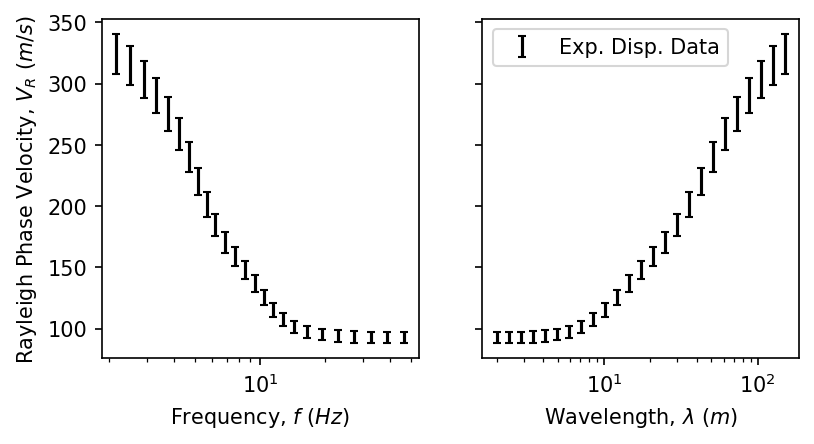

In [3]:
domain = 'wavelength'       # 'frequency' or 'wavelength'
resample_type = 'log'       # 'log' or 'linear'
pmin = 2                    # Minimum value after resampling in units of domain
pmax = 150                  # Maximum value after resampling in units of domain
pn = 25                     # Number of samples
target_name = "Tar5"        # Name of target file (without the .target suffix)
version = "2"               # Major version of Geopsy "2" or "3"

# Resample
tar.resample(pmin=pmin, pmax=pmax, pn=pn, res_type=resample_type, domain=domain, inplace=True)

# Save to Disk
if os.path.isdir("0_targets/")==False:
    os.mkdir("0_targets/")
tar.to_target(f"0_targets/{target_name}", version=version)
plotter(tar)

## Selecting the Inversion Parameterizations

1. Enter upper and lower limits for `vp`, `vs`, `Poisson's ratio`, and `mass density`. 
2. Select the `Layering Ratio` and/or `Layering by Number` parameterizations you would like to consider, use `ctrl+click` to select multiple. Note that this notebook assumes `vp` and `vs` layering are equal to the selected layers and that `vp` is linked to the `vs` parameterization. Only a single layer is assumed for `Poisson's ratio` and `mass density`.
3. Review your selections, then proceed to and run the next cell.
 
__Be cautious when making your selections as they can strongly bias your inversion's final result.__
 
[Back to top](#License-Information)

In [4]:
vpstep = 100
vpMin = widgets.FloatText(value=100, step=vpstep, description=r'\(V_{p,min} (m/s)\)')
vpMax = widgets.FloatText(value=2500, step=vpstep, description=r'\(V_{p,max} (m/s)\)')
vpRev = widgets.Checkbox(value=False,description='Allow Vp Decrease')

vstep = 50
vMin = widgets.FloatText(value=round(min(tar.velocity)*0.9,0), step=vstep, description=r'\(V_{s,min} (m/s)\)')
vMax = widgets.FloatText(value=round(max(tar.velocity)*1.1,0), step=vstep, description=r'\(V_{s,max} (m/s)\)')
vRev = widgets.Checkbox(value=False, description='Allow Vs Decrease')

nustep = 0.05
nuMin = widgets.FloatText(value=0.2, step=nustep, description=r'\(\nu_{min}\)')
nuMax = widgets.FloatText(value=0.5, step=nustep, description=r'\(\nu_{max}\)')

rhstep = 0.05
rhMin = widgets.FloatText(value=2000, step=rhstep, description=r'\(\rho_{min} (kg/m^{3})\)')
rhMax = widgets.FloatText(value=2000, step=rhstep, description=r'\(\rho_{max} (kg/m^{3})\)')

LRs = widgets.SelectMultiple(description='By Ratio', 
                             options=[('LR: 1.2',1.2), ('LR: 1.3',1.3), ('LR: 1.5',1.5), ('LR: 2.0',2.0), ('LR: 2.5',2.5),
                                      ('LR: 3.0',3.0), ('LR: 3.5',3.5), ('LR: 5.0',5.0), ('LR: 6.0',6.0), ('LR: 7.0',7.0)],
                             layout=widgets.Layout(height='200px'))
LNs = widgets.SelectMultiple(description='By Number', 
                             options=[('LN: 3',3),('LN: 4',4),('LN: 5',5),
                                      ('LN: 6',6),('LN: 7',7),('LN: 8',8),('LN: 9',9),
                                      ('LN: 10',10), ('LN: 15',15), ('LN: 20',20),],
                             layout=widgets.Layout(height='200px'))

Vs = widgets.VBox([vMin, vMax, vRev])
Vp = widgets.VBox([vpMin, vpMax, vpRev])
Nu = widgets.VBox([nuMin, nuMax])
Rh = widgets.VBox([rhMin, rhMax])
ui_new = widgets.VBox([widgets.HBox([Vp, Nu]), widgets.HBox([Vs, Rh]), widgets.HBox([LRs, LNs])])
display(ui_new)

### Write Parameterizations to Disk

[Back to top](#License-Information)

In [5]:
depth_factor = 3
wmin, wmax = min(tar.wavelength), max(tar.wavelength)

# Parameterize Mass Density
if rhMin.value == rhMax.value:
    rh = swprepost.Parameter.from_fx(rhMin.value)
else:
    rh = swprepost.Parameter.from_ln(wmin=wmin, wmax=wmax, nlayers=1, par_min=rhMin.value, par_max=rhMax.value, par_rev=False)
    
# Parameterize Poisson's Ratio
if nuMin.value == nuMax.value:
    raise ValueError("Do not fix Poisson's ratio")
else:
    pr = swprepost.Parameter.from_ln(wmin=wmin, wmax=wmax, nlayers=1, par_min=nuMin.value, par_max=nuMax.value, par_rev=False)

if os.path.isdir("1_parameters/")==False:
    os.mkdir("1_parameters/")

# Parameterize Vs using Layering by Number (LN)
for ln in LNs.value:
    vs = swprepost.Parameter.from_ln(wmin=wmin, wmax=wmax, nlayers=ln, par_min=vMin.value, par_max=vMax.value, par_rev=vRev.value, depth_factor=depth_factor)
    vp = swprepost.Parameter.from_parameter_and_link(par_min=vpMin.value, par_max=vpMax.value, par_rev=vpRev.value, existing_parameter=vs, ptype="vs")
    par=swprepost.Parameterization(vp=vp, pr=pr, vs=vs, rh=rh)
    par.to_param(f"1_parameters/LN{ln}", version=version)

# Parameterize Vs using Layering Ratio (LR)
for lr in LRs.value:
    vs = swprepost.Parameter.from_lr(wmin=wmin, wmax=wmax, lr=lr, par_min=vMin.value, par_max=vMax.value, par_rev=vRev.value, depth_factor=depth_factor)
    vp = swprepost.Parameter.from_parameter_and_link(par_min=vpMin.value, par_max=vpMax.value, par_rev=vpRev.value, existing_parameter=vs, ptype="vs")
    par=swprepost.Parameterization(vp=vp, pr=pr, vs=vs, rh=rh)
    par.to_param(f"1_parameters/LR{int(lr*10)}", version=version)


## Running the Inversion

There are two ways to run your inversion(s):

1. Locally using the `.target` and `.param` files which have been written in the previous sections. (Not Recommended for reasons provided below)
2. Remotely using the DesignSafe-CI application `SWbatch`. (Recommended)

See the appropriate section below for instructions.

[Back to top](#License-Information)

### If running locally

_Note: Running locally is generally not recommended as the DesignSafe-CI application `SWbatch` has been specifically designed to integrate with the inputs generated by this notebook and generate the outputs expected from this notebook. However, as some will undoubtedly still want to run their inversion's locally instructions are provided below._

1. Load the `.target` and `.param` files into Dinver. The `.target` and `.param` files are located in the `0_targets` and `1_parameters` directories created by this notebook.
2. Setup the inversion's tuning parameters. Full details are provided in Vantassel and Cox (2020, however for completeness a brief summary is provided here. Number of independent runs (i.e., Ntrial) should be greater than 3, It*Ns > 50,000 (e.g., It=200, Ns=250), Nr ~= 100, Ns0>Nr (e.g., Ns0=10000).
4. After completing your inversions export the desired number of ground models and dispersion curves to text format, using the Geopsy command line interface. Refer to the provided sample outputs in the `3_text` directory for the naming conventions assumed by this notebook.


### If running remotely on DesignSafe-CI

_Note: This functionality is only available to those running this notebook on DesignSafe-CI._ __It will not work locally.__

1. Read through the cell below and select your inversion tuning parameters.
2. When done, run the cell and inspect the output.
3. If there is an issue edit the cell and run it again.
4. Finally, run the following cell to launch your inversion on Stampede2. To monitor the progress of your inversion go to `Research Workbench>Workspace>Job Status`.


In [ ]:
from agavepy.agave import Agave
from agavepy.async import AgaveAsyncResponse
ag=Agave.restore()

# Inputs
job_name = "EX0"      # Name of job (will appear in workspace)
run_time = "00:05:00" # Runtime for simulation in (HH:MM:SS) format
run_name = "EX"       # Run name (will appear as prefix to groundmodel and dispersioncurve files)
n_trials = "2"        # Number of trials to perform, a minimum of 3 is recommended.
It = "20"             # Number of iterations, a minimum of 200 is recommended.
Ns = "25"             # Number of samples per iteration, a minimum of 250 is recommended.
Nr = "100"            # Number of models to consider when resampling, 100 is recommended.
Ns0 = "100"           # Number of initial samples, any value greater than Nr is recommended.

# Outputs
nprofile = "3"        # Number of ground models and dispersion curves to export
# Frequency sampling of theoretical dispersion curves
fmin = "1"            # Minimum frequency in Hz
fmax = "50"           # Maximum frequency in Hz
fnum = "25"           # Number of frequency samples

full=%pwd
usr=ag.profiles.get()["username"]
shrt=full[20::]
job_description = {
    "name":job_name,
    "appId":"swbatch-0.2.1",
    "batchQueue":"development",
    "nodeCount":1,
    "maxRunTime":run_time,
    "archive":True,
    "inputs":{
        "workingDirectory":"agave://designsafe.storage.default/"+usr+shrt
    },
    "parameters":{
      "name":run_name,
      "ntrial":n_trials,
      "Ns0":Ns0,
      "It":It,
      "Ns":Ns,
      "Nr":Nr,
      "nprofile":nprofile,
      "fnum":fnum,
      "fmin":fmin,
      "fmax":fmax,
    }
}
print("Confirm job information before continuing: ")
display(job_description)

In [ ]:
# Run cell to launch simulation
job = ag.jobs.submit(body=job_description)
asrp = AgaveAsyncResponse(ag, job)

## Post-processing the Inversion Results

### Importing the Data

In order for the data to import correctly you must provide a relative or full path to the `3_text` directory.

1. For those running this as a tutorial, no changes are necessary here.
2. For those running this locally, it is recommended you follow the same directory structure provided in the example, and therefore no changes are necessary.
3. For those running this remotely on DesignSafe-CI, you will need to replace the `full_path` variable in the cell below with the full path to the `3_text` directory containing your results. For your convenience, an incomplete `full_path` variable is provided below and commented out. To complete the path you will need to replace `<path_here>` with the actual path. The easiest way to find the full path to your data is by using the Job Status viewer by selecting `Research Workbench>Job Status>Your Desired Job>View` which will bring you to your job results. Alternatively, you can move the `3_text` directory form the job archive into the current directory, in which no changes to `full_path` are necessary.

[Back to top](#License-Information)

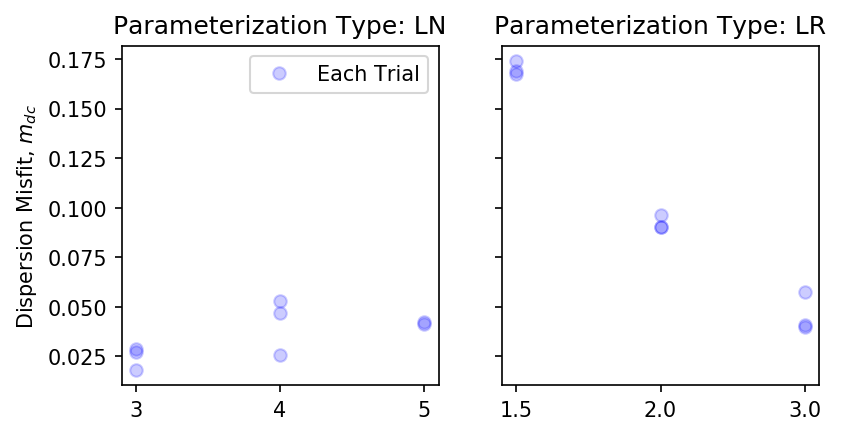

In [6]:
ndc = 1             # Number of dispersion curves, may use "all"
nrayleigh = 1       # Number of rayleigh modes, may use "all"
nlove = 0           # Number of love modes, may use "all"
ngm = 1             # Number of ground models, may use "all"

full_path = "./3_text/"
# full_path = "/home/jupyter/MyData/archive/<path_here>/3_text/"
fnames = glob.glob(full_path + "*_DC.txt")
fnames.sort(key=lambda x: int(re.findall(r".*[\\/].*_.*[LF][TRN][IL]?(\d+)_Tr\d+_DC.txt$",x)[0]))

dcs, gms = {}, {}
for fname in fnames:
    filename, partype, parnumber, seed = re.findall(r".*[\\/](.*_.*([LF][TRN][IL]?)(\d+)_Tr(\d+)_DC.txt)$", fname)[0]
    
    # Divide LR by 10
    if partype in ['LR']:
        parnumber = str(int(parnumber)/10)
    
    # Save by parameterization
    if partype not in dcs.keys():
        dcs.update({partype:{}})
        gms.update({partype:{}})
        firstpass = True
        
    # Save by parameterization number        
    if parnumber not in dcs[partype].keys():
        dcs[partype].update({parnumber:{}})
        gms[partype].update({parnumber:{}})
        
    # Save by trial
    if os.path.getsize(fname) == 0:
        print(f"fname = {fname}, is empty skipping!")
    else:
        dcs[partype][parnumber].update({seed:swprepost.DispersionSuite.from_geopsy(fname=fname, nsets=ndc, 
                                                                                   nrayleigh=nrayleigh, nlove=nlove)})
        gms[partype][parnumber].update({seed:swprepost.GroundModelSuite.from_geopsy(fname=fname[:-6]+"GM.txt", nmodels=ngm)})
    
ncols = len(list(dcs.keys()))
fig, axs = plt.subplots(nrows=1, ncols=ncols, sharey=True, figsize=(3*ncols,3), dpi=150)
axs = [axs] if type(axs) != np.ndarray else axs
bestseed = {}
blabel = "Each Trial"
fiter = True
for ax, partype in zip(axs, dcs):
    bestseed.update({partype:{}})
    for parnumber in dcs[partype]:
        seeds, misfits = [], []
        for seed in dcs[partype][parnumber].keys():
            seeds.append(seed)
            misfits.append(dcs[partype][parnumber][seed].misfits[0])
            ax.plot(parnumber, misfits[-1], 'bo', label=blabel, alpha=0.2)
            blabel = None
        bestseed[partype].update({parnumber:seeds[misfits.index(min(misfits))]})
    if fiter:
        fiter = False
        ax.legend()
    ax.set_title("Parameterization Type: "+partype)
axs[0].set_ylabel("Dispersion Misfit, "+"$m_{dc}$")
plt.show()

### General Settings

_Note: If you are considering more than six parameterizations, you must provide additional colors in the list below._

[Back to top](#License-Information)

In [7]:
colors = ["#adefbb", "#588c7e","#e6c833","#f2ae72","#e97816","#a366ff"]

### Plotting Dispersion

[Back to top](#License-Information)

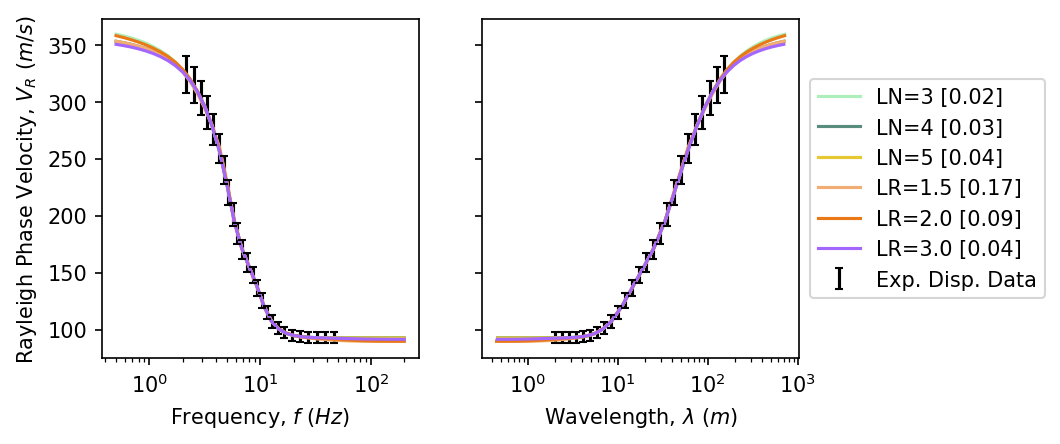

In [8]:
ndc = 1       # Number of "best" dispersion curves to plot, may use "all".
nray = 1      # Number of Rayleigh-wave modes to plot, may use "all".
nlov = 0      # Number of Love-wave modes to plot, may use "all".

fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(6,3), dpi=150)

# Plot the Theoretical Modes of Inversion Ground Models.
color_id = 0
for partype in dcs:
    for parnumber in dcs[partype]:
        best = bestseed[partype][parnumber]
        suite = dcs[partype][parnumber][best]
        label = f"{partype}={parnumber} {suite.misfit_repr(nmodels=ndc)}"
        
        color = colors[color_id]
        for dc_count, dcset in enumerate(suite):
            for mode in range(nray):
                try:
                    dc = dcset.rayleigh[mode]
                    axs[1].plot(dc.wavelength, dc.velocity, color=color, label=label)
                    label=None
                    axs[0].plot(dc.frequency, dc.velocity, color=color, label=label)
                except KeyError:
                    print(f"Could not find mode {mode}.")                    
            if dc_count+1 == ndc:
                break
        color_id += 1
    
# Plot the Experimental Dispersion Curve
ax = axs[0]
tar.plot(ax=ax)

ax = axs[1]
tar.plot(ax=ax, x="wavelength")
ax.legend(loc="center left", bbox_to_anchor=(1,0.5))
ax.set_ylabel("")

plt.show()

### Plotting Vs

[Back to top](#License-Information)

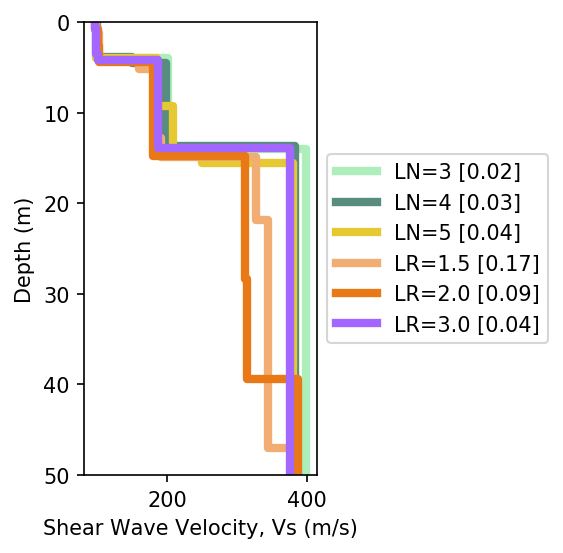

In [9]:
ngm = 1             # Number of GroundModels
plot_depth = 50     # Maximum plot depth in meters

fig, ax = plt.subplots(nrows=1, figsize=(2, 4), dpi=150)
color_id = 0
all_gm = []
for partype in gms:
    for parnumber in gms[partype]:
        best = bestseed[partype][parnumber]
        suite = gms[partype][parnumber][best]    
        
        label = f"{partype}={parnumber} {suite.misfit_repr(nmodels=ngm)}"
        for gm in suite[:ngm]:
            all_gm.append(gm)
            ax.plot(gm.vs2, gm.depth, color=colors[color_id], linewidth=4, label=label)
            label=None
        color_id += 1
    ax.set_ylim(plot_depth, 0)
    ax.set_xlabel('Shear Wave Velocity, Vs (m/s)')
    ax.set_ylabel('Depth (m)')
    ax.legend(bbox_to_anchor=(1, 0.5), loc='center left')
plt.show()

### Plotting Uncertainty

[Back to top](#License-Information)

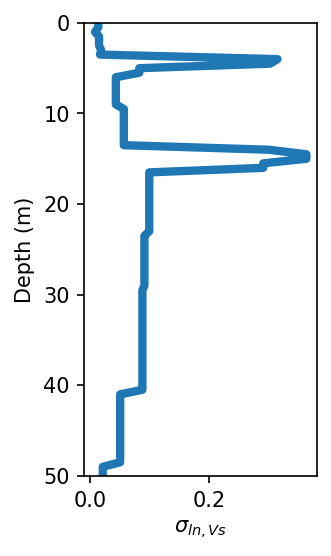

In [10]:
fig, ax = plt.subplots(nrows=1, figsize=(2, 4), dpi=150)
color_id = 0
all_gm_suite = swprepost.GroundModelSuite.from_list(all_gm)
ddepth, dsigmaln = all_gm_suite.sigma_ln()
ax.plot(dsigmaln, ddepth, linewidth=4)
ax.set_ylim(plot_depth, 0)
ax.set_xlabel(r"$\sigma_{ln,Vs}$")
ax.set_ylabel("Depth (m)")
plt.show()